In [1]:
!pip install jams
!pip install rdflib requests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.7/90.7 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for jams: filename=jams-0.3.4-py3-none-any.whl size=64901 sha256=70dabe4f6485d2fc2d4229c8ba4b97824ed4966b361e8b95c899acb03ca1c736
  Stored in directory: /root/.cache/pip/wheels/28/9a/f7/fb386b6bc5a75a3ef198a50e98b221e94a381472332b65cf24
  Created wheel for mir_eval: filename=mir_eval-0.7-py3-none-any.whl size=100699 sha256=1054e990a73d6bed65f6864278126bc092c813c8cf660b87e1ec67fa22a8f001
  Stored in directory: /root/.cache/pip/wheels/3e/2f/0d/dda9c4c77a170e21356b6afa2f7d9bb078338634ba05d94e3f
Successfully built jams mir_eval
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.9/531.9 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.2 MB/s eta 0:00:00


In [2]:
import json
import requests
from bs4 import BeautifulSoup

# Funzione per ottenere la lista di file .jams dalla pagina GitHub
def get_jams_file_urls(github_page_url):
    response = requests.get(github_page_url)
    response.raise_for_status()
    soup = BeautifulSoup(response.content, 'html.parser')

    # Trova tutti i link ai file .jams nella pagina
    file_urls = []
    for link in soup.find_all('a', href=True):
        if link['href'].endswith('.jams'):
            # Genera il corretto URL "raw" per ciascun file
            file_url = "https://raw.githubusercontent.com" + link['href'].replace('/blob', '')
            file_urls.append(file_url)

    return file_urls

# Funzione per scaricare il file .jams da un URL
def download_jams_file(url):
    response = requests.get(url)
    response.raise_for_status()
    return response.json()

# Funzione per estrarre gli ultimi due accordi per ciascuna sezione, includendo la tonalità
def extract_final_chords_per_section(jams_data):
    # Estraggo le annotazioni degli accordi, delle sezioni e delle tonalità
    dati_estratti = []
    dati_estratti1 = []
    key_data = []
    key_mode_count = 0

    for annotation in jams_data['annotations']:
        if annotation['namespace'] == 'chord':
            for chord_event in annotation['data']:
                # Salvo i dati
                dati_estratti.append({
                    'chord': chord_event['value'],
                    'time': chord_event['time'],
                    'duration': chord_event.get('duration', 0)  # Potrebbe esserci o meno una durata
                })
            chords = dati_estratti

        elif annotation['namespace'] == 'segment_open':
            for section_event in annotation['data']:

                dati_estratti1.append({
                    'section': section_event['value'],
                    'time': section_event['time'],
                    'duration': section_event.get('duration', 0)  # Potrebbe esserci o meno una durata
                })
            sections = dati_estratti1

        elif annotation['namespace'] == 'key_mode':
            key_mode_count += 1
            if key_mode_count == 2:
                for key_event in annotation['data']:

                    key_data.append({
                        'key': key_event['value'],
                        'time': key_event['time'],
                        'duration': key_event.get('duration', 0)
                    })


    # Estraggo i due accordi finali di ciascuna sezione
    final_chords_per_section = []
    for section in sections:
        section_end = section['time'] + section['duration']  # Calcolo la fine della sezione

        # Filtra gli accordi che si concludono prima della fine della sezione (considera durata)
        section_chords = [chord for chord in chords if chord['time'] + chord['duration'] <= section_end and chord['time'] > section_end - 3]

        # Trova la tonalità
        section_key = next((key['key'] for key in key_data if key['time'] <= section['time'] <= key['time'] + key['duration']), 'Unknown')

        # Prendi gli ultimi due accordi (se esistono)
        if len(section_chords) >= 2:
            final_two_chords = section_chords[-2:]  # Ultimi due accordi
            final_chords_per_section.append({
                'section': section['section'],
                'start_time': section['time'],
                'end_time': section_end,
                'key': section_key,  # Aggiungi la tonalità
                'final_chords': [(chord['chord'], chord['time']) for chord in final_two_chords]
            })

    return final_chords_per_section

# Funzione principale per analizzare tutti i file nella pagina GitHub
def analyze_all_jams_files(github_page_url):
    # ottengo la lista dei file .jams
    jams_file_urls = get_jams_file_urls(github_page_url)

    all_final_chords = []

    for file_url in jams_file_urls:
        #print(f"Analizzando il file: {file_url}")
        jams_data = download_jams_file(file_url)

        final_chords_per_section = extract_final_chords_per_section(jams_data)

        all_final_chords.extend(final_chords_per_section)

    return all_final_chords


github_page_url = "https://github.com/smashub/choco/tree/main/partitions/schubert-winterreise/choco/audio/jams"

final_chords = analyze_all_jams_files(github_page_url)

In [3]:
final_chords

[{'section': 'I',
  'start_time': 1.26,
  'end_time': 13.4,
  'key': 'C:min',
  'final_chords': [('C:(b3,5)/G', 11.24), ('G:(3,5)', 12.3)]},
 {'section': 'A',
  'start_time': 13.4,
  'end_time': 31.68,
  'key': 'C:min',
  'final_chords': [('C:(b3,5)', 30.14), ('A#:(3,5)/D', 31.14)]},
 {'section': 'C',
  'start_time': 49.0,
  'end_time': 68.08,
  'key': 'C:min',
  'final_chords': [('C:(b3,5)/G', 65.76), ('G:(3,5,b7)', 66.92)]},
 {'section': 'I',
  'start_time': 68.08,
  'end_time': 80.62,
  'key': 'C:min',
  'final_chords': [('C:(b3,5)/G', 78.44), ('G:(3,5,b7)', 79.48)]},
 {'section': 'A',
  'start_time': 80.62,
  'end_time': 98.92,
  'key': 'C:min',
  'final_chords': [('C:(b3,5)', 97.38), ('A#:(3,5)/D', 98.36)]},
 {'section': 'C',
  'start_time': 116.24,
  'end_time': 135.32,
  'key': 'C:min',
  'final_chords': [('C:(b3,5)/G', 133.0), ('G:(3,5,b7)', 134.14)]},
 {'section': 'I',
  'start_time': 135.32,
  'end_time': 147.86,
  'key': 'C:min',
  'final_chords': [('C:(b3,5)/G', 145.68), ('

In [4]:
len(final_chords)

396

In [5]:
from google.colab import files

uploaded = files.upload()

Saving Cadence1309.rdf to Cadence1309.rdf


In [6]:
from rdflib import Graph, Namespace, URIRef, Literal
from rdflib.namespace import RDF, RDFS, XSD

# Carico il grafo RDF dall'a tua 'ontologia
g = Graph()
g.parse("Cadence1309.rdf", format="xml")

# Definisco il namespace dell'ontologia
ns = Namespace("http://www.example.com/cadences.owl#")

In [7]:
# Mappa delle scale diatoniche maggiori e minori
diatonic_major_scale = {
    'C': ['C', 'D', 'E', 'F', 'G', 'A', 'B'],
    'G': ['G', 'A', 'B', 'C', 'D', 'E', 'F#'],
    'D': ['D', 'E', 'F#', 'G', 'A', 'B', 'C#'],
    'A': ['A', 'B', 'C#', 'D', 'E', 'F#', 'G#'],
    'E': ['E', 'F#', 'G#', 'A', 'B', 'C#', 'D#'],
    'B': ['B', 'C#', 'D#', 'E', 'F#', 'G#', 'A#'],
    'F#': ['F#', 'G#', 'A#', 'B', 'C#', 'D#', 'E#'],
    'C#': ['C#', 'D#', 'E#', 'F#', 'G#', 'A#', 'B#'],
    'F': ['F', 'G', 'A', 'Bb', 'C', 'D', 'E'],
    'Bb': ['Bb', 'C', 'D', 'Eb', 'F', 'G', 'A'],
    'Eb': ['Eb', 'F', 'G', 'Ab', 'Bb', 'C', 'D'],
    'Ab': ['Ab', 'Bb', 'C', 'Db', 'Eb', 'F', 'G'],
    'Db': ['Db', 'Eb', 'F', 'Gb', 'Ab', 'Bb', 'C'],
    'Gb': ['Gb', 'Ab', 'Bb', 'Cb', 'Db', 'Eb', 'F'],
    'Cb': ['Cb', 'Db', 'Eb', 'Fb', 'Gb', 'Ab', 'Bb'],
    'G#': ['G#', 'A#', 'B#', 'C#', 'D#', 'E#', 'Fx'],
    'A#': ['A#', 'B#', 'Cx', 'D#', 'E#', 'Fx', 'Gx'],
    'D#': ['D#', 'E#', 'Fx', 'G#', 'A#', 'B#', 'Cx'],
    'E#': ['E#', 'Fx', 'Gx', 'A#', 'B#', 'Cx', 'Dx'],
    'Fb': ['Fb', 'Gb', 'Ab', 'Bbb', 'Cb', 'Db', 'Eb'],
    'B#': ['B#', 'Cx', 'Dx', 'E#', 'Fx', 'Gx', 'Ax']
}

diatonic_minor_scale = {
    'A': ['A', 'B', 'C', 'D', 'E', 'F', 'G'],
    'E': ['E', 'F#', 'G', 'A', 'B', 'C', 'D'],
    'B': ['B', 'C#', 'D', 'E', 'F#', 'G', 'A'],
    'F#': ['F#', 'G#', 'A', 'B', 'C#', 'D', 'E'],
    'C#': ['C#', 'D#', 'E', 'F#', 'G#', 'A', 'B'],
    'G#': ['G#', 'A#', 'B', 'C#', 'D#', 'E', 'F#'],
    'D#': ['D#', 'E#', 'F#', 'G#', 'A#', 'B', 'C#'],
    'A#': ['A#', 'B#', 'C#', 'D#', 'E#', 'F#', 'G#'],
    'D': ['D', 'E', 'F', 'G', 'A', 'Bb', 'C'],
    'G': ['G', 'A', 'Bb', 'C', 'D', 'Eb', 'F'],
    'C': ['C', 'D', 'Eb', 'F', 'G', 'Ab', 'Bb'],
    'F': ['F', 'G', 'Ab', 'Bb', 'C', 'Db', 'Eb'],
    'Bb': ['Bb', 'C', 'Db', 'Eb', 'F', 'Gb', 'Ab'],
    'Eb': ['Eb', 'F', 'Gb', 'Ab', 'Bb', 'Cb', 'Db'],
    'Ab': ['Ab', 'Bb', 'Cb', 'Db', 'Eb', 'Fb', 'Gb'],
    'Db': ['Db', 'Eb', 'Fb', 'Gb', 'Ab', 'Bbb', 'Cb'],
    'Gb': ['Gb', 'Ab', 'Bb', 'Cb', 'Db', 'Ebb', 'Fb'],
    'A#': ['A#', 'B#', 'C#', 'D#', 'E#', 'F#', 'G#'],
    'D#': ['D#', 'E#', 'F#', 'G#', 'A#', 'B', 'C#'],
    'E#': ['E#', 'F##', 'G#', 'A#', 'B#', 'C##', 'D#'],
    'Fb': ['Fb', 'Gb', 'Abb', 'Bbb', 'Cb', 'Db', 'Ebb'],
    'B#': ['B#', 'C##', 'D#', 'E#', 'F##', 'G#', 'A#']
}


In [8]:
# Funzione per determinare il grado armonico dell'accordo rispetto alla tonalità
def determina_grado_accordo(chord, key):
    # Estraggo la nota fondamentale dell'accordo, ignorando eventuali inversioni o alterazioni
    note = chord.split(':')[0].split('/')[0]

    # Identifico se la tonalità è maggiore o minore (gestisce notazioni come "E:maj" o "A:min")
    is_minor = 'min' in key
    key_root = key.split(':')[0]  # Nota della tonalità

    # Seleziona la scala corretta (maggiore o minore)

    if is_minor:
        scale = diatonic_minor_scale.get(key_root)
    else:
        scale = diatonic_major_scale.get(key_root)

    # Check se la scala esiste per la tonalità fornita
    if not scale:
        print(f"Errore: tonalità {key_root} non trovata in diatonic_major_scale o diatonic_minor_scale")
        return None

    if scale and note in scale:
        degree = scale.index(note) + 1
        degree_mapping = ['I', 'II', 'III', 'IV', 'V', 'VI', 'VII']

        return degree_mapping[degree - 1]
    else:
        #print(f"NONE: Scala  {scale}, nota {note}, key{key}, chord: {chord}")
        return None

# Funzione per determinare il tipo di cadenza
def determina_tipo_cadenza(preceding_chord, following_chord, key):
    preceding_degree = determina_grado_accordo(preceding_chord, key)
    following_degree = determina_grado_accordo(following_chord, key)
    #print(f"{preceding_degree} -> {following_degree}")

      # Cadenza perfetta (V -> I in posizione fondamentale)
    if preceding_degree == 'V' and following_degree == 'I' and '/' not in preceding_chord and '/' not in following_chord:
        return ns.Perfect, 'Perfect'

    # Cadenza imperfetta (V -> I con inversione)
    elif preceding_degree == 'V' and following_degree == 'I' and ('/' in preceding_chord or '/' in following_chord):
        return ns.Imperfect, 'Imperfect'

    # Cadenza d'inganno (V -> VI generica)
    elif preceding_degree == 'V' and  following_degree=='VI':
        return ns.Deceptive, 'Deceptive'

    # Cadenza plagale (IV -> I)
    elif preceding_degree == 'IV' and following_degree == 'I':
        return ns.Plagal, 'Plagal'

    # Cadenza avoided (V -> not(I, VI))
    elif preceding_degree == 'V' and  following_degree not in ['I', 'VI']:
        return ns.Avoided, 'Avoided'

    # Cadenza sospesa (['I', 'II', 'IV', 'VI'] -> V)
    elif preceding_degree in ['I', 'II', 'IV', 'VI'] and following_degree == 'V':
        return ns.Half, 'Half'

    else:
      # Default, nel caso non sia cadenza principale
      return ns.Cadence, 'Cadence'

In [9]:
from rdflib import Graph, URIRef, Literal, Namespace
from rdflib.namespace import RDF, XSD


# Funzione per popolare l'ontologia
def popola_ontologia(dati, ontologia_path, output_path):

    # Contatore globale per le cadenze
    cadence_counter = 1

    for dato in dati:
        section_name = dato['section']
        key_name = dato['key']
        final_chords = dato['final_chords']

        # Itera su accordi per det. la cadenza
        for i in range(len(final_chords) - 1):
            preceding_chord_name = final_chords[i][0]
            following_chord_name = final_chords[i + 1][0]

            # URI  sezione
            section_uri = URIRef(ns + f"section_{section_name}")
            g.add((section_uri, RDF.type, ns.Section))
            g.add((section_uri, ns.hasName, Literal(section_name, datatype=XSD.string)))

            # URI tonalità (Key)
            key_uri = URIRef(ns + f"key_{key_name.replace(':', '_')}")
            g.add((key_uri, RDF.type, ns.Key))
            g.add((key_uri, ns.hasName, Literal(key_name, datatype=XSD.string)))

            # Determina il tipo di cadenza
            cadenza_type_uri, cadenza_type_name = determina_tipo_cadenza(preceding_chord_name, following_chord_name, key_name)

            # Usa un contatore per creare un URI univoco ma ordinato per cadenza
            cadenza_uri = URIRef(ns + f"cadence_{cadenza_type_name}_{section_name}_{cadence_counter}")
            #g.add((cadenza_uri, RDF.type, ns.Cadence))
            g.add((cadenza_uri, RDF.type, cadenza_type_uri))
            g.add((cadenza_uri, ns.belongsToSection, section_uri))

            # Incrementa il contatore delle cadenze
            cadence_counter += 1

            # URI accordi
            preceding_chord_uri = URIRef(ns + f"chord_{preceding_chord_name.replace(':', '_').replace('/', '_')}")
            following_chord_uri = URIRef(ns + f"chord_{following_chord_name.replace(':', '_').replace('/', '_')}")
            g.add((preceding_chord_uri, RDF.type, ns.Chord))
            g.add((preceding_chord_uri, ns.hasName, Literal(preceding_chord_name, datatype=XSD.string)))
            g.add((following_chord_uri, RDF.type, ns.Chord))
            g.add((following_chord_uri, ns.hasName, Literal(following_chord_name, datatype=XSD.string)))

            # Aggiungi gradi e accordi alla cadenza
            preceding_degree = determina_grado_accordo(preceding_chord_name, key_name)
            following_degree = determina_grado_accordo(following_chord_name, key_name)

            if preceding_degree:
                degree_uri_preceding = URIRef(ns + f"degree_{preceding_degree}_{preceding_chord_name}_{key_name}")
                g.add((cadenza_uri, ns.hasPrecedingDegree, degree_uri_preceding))
                g.add((degree_uri_preceding, ns.hasChord, preceding_chord_uri))
                g.add((degree_uri_preceding, ns.hasKey, key_uri))

            if following_degree:
                degree_uri_following = URIRef(ns + f"degree_{following_degree}_{following_chord_name}_{key_name}")
                g.add((cadenza_uri, ns.hasFollowingDegree, degree_uri_following))
                g.add((degree_uri_following, ns.hasChord, following_chord_uri))
                g.add((degree_uri_following, ns.hasKey, key_uri))

    # Salva l'ontologia aggiornata in un file
    g.serialize(destination=output_path, format="xml")


# popolo ontologia
ontologia_path = 'Cadence1209.rdf'
output_path = 'ontologia_popolata.owl'

popola_ontologia(final_chords, ontologia_path, output_path)


In [10]:
# Stampa tutti i dati del grafo
print("Triples presenti nel grafo RDF:")
for subj, pred, obj in g:
    print(f"Soggetto: {subj}")
    print(f"Predicato: {pred}")
    print(f"Oggetto: {obj}")
    print("-----")

Output streaming troncato alle ultime 5000 righe.
Soggetto: http://www.example.com/cadences.owl#cadence_Imperfect_A_239
Predicato: http://www.w3.org/1999/02/22-rdf-syntax-ns#type
Oggetto: http://www.example.com/cadences.owl#Imperfect
-----
Soggetto: http://www.example.com/cadences.owl#degree_V_E:(b3,5)/B_A:min
Predicato: http://www.example.com/cadences.owl#hasChord
Oggetto: http://www.example.com/cadences.owl#chord_E_(b3,5)_B
-----
Soggetto: http://www.example.com/cadences.owl#cadence_Perfect_A1_324
Predicato: http://www.example.com/cadences.owl#hasFollowingDegree
Oggetto: http://www.example.com/cadences.owl#degree_I_D:(b3,5)_D:min
-----
Soggetto: http://www.example.com/cadences.owl#chord_F_(b3,5)
Predicato: http://www.example.com/cadences.owl#hasName
Oggetto: F:(b3,5)
-----
Soggetto: http://www.example.com/cadences.owl#cadence_Perfect_A_363
Predicato: http://www.example.com/cadences.owl#hasPrecedingDegree
Oggetto: http://www.example.com/cadences.owl#degree_V_E:(3,5,b7)_A:maj
-----
Sog

In [11]:
from rdflib import Graph, Namespace


def load_ontology(ontology_path):
    g = Graph()
    g.parse(ontology_path)
    return g

# Funzione per rimuovere tutti gli individuals dall'ontologia
def remove_individuals(ontology_path, output_path):
    g = load_ontology(ontology_path)

    ns = Namespace("http://www.example.com/cadences.owl#")

    # Query per selezionare tutti gli individuals nell'ontologia
    query = """
    PREFIX owl: <http://www.w3.org/2002/07/owl#>
    SELECT ?individual
    WHERE {
      ?individual a owl:NamedIndividual .
    }
    """

    # Esegui la query per ottenere tutti gli individuals
    individuals = g.query(query)

    # Rimuovi tutti gli individuals
    for row in individuals:
        individual_uri = row.individual
        # Rimuovi tutte le triple associate a ciascun individual
        g.remove((individual_uri, None, None))

    # Salva l'ontologia modificata in un nuovo file
    g.serialize(destination=output_path, format='xml')

    print(f"Rimossi gli individuals e salvato il nuovo file RDF in {output_path}")


ontology_path = 'ontologia_popolata.owl'  # Il file RDF con gli individuals
output_path = 'ontologia_senza_individuals.owl'  # Il file RDF senza gli individuals
remove_individuals(ontology_path, output_path)


Rimossi gli individuals e salvato il nuovo file RDF in ontologia_senza_individuals.owl


In [12]:
def conta_cadenze_per_sezione(ontology_path):
    g = Graph()
    g.parse(ontology_path)

    query = """
    PREFIX : <http://www.example.com/cadences.owl#>
    SELECT ?section ?cadenceType (COUNT(?cadence) AS ?cadenceCount)
    WHERE {
      ?cadence a ?cadenceType ;
               :belongsToSection ?section .
      FILTER (?cadenceType IN (:Perfect, :Imperfect, :Deceptive, :Plagal, :Half, :Cadence, :Avoided))
    }
    GROUP BY ?section ?cadenceType
    ORDER BY ?section
    """

    results = g.query(query)
    cadence_data = {}
    for row in results:
        section = str(row.section).split("#")[-1]
        cadence_type = str(row.cadenceType).split("#")[-1]
        cadence_count = int(row.cadenceCount.value)
        print(f"Sezione: {section:<15} Cadenza: {cadence_type:<15} Conteggio: {cadence_count:<10}")
        if section not in cadence_data:
            cadence_data[section] = {}

        cadence_data[section][cadence_type] = cadence_count
    return cadence_data


# Esegui il conteggio
cadence_data = conta_cadenze_per_sezione('ontologia_senza_individuals.owl')

Sezione: section_A       Cadenza: Perfect         Conteggio: 14        
Sezione: section_A       Cadenza: Imperfect       Conteggio: 16        
Sezione: section_A       Cadenza: Cadence         Conteggio: 34        
Sezione: section_A       Cadenza: Half            Conteggio: 6         
Sezione: section_A1      Cadenza: Perfect         Conteggio: 10        
Sezione: section_A1      Cadenza: Cadence         Conteggio: 10        
Sezione: section_A2      Cadenza: Perfect         Conteggio: 14        
Sezione: section_A2      Cadenza: Cadence         Conteggio: 22        
Sezione: section_A3      Cadenza: Half            Conteggio: 2         
Sezione: section_A3      Cadenza: Cadence         Conteggio: 2         
Sezione: section_Ab      Cadenza: Half            Conteggio: 8         
Sezione: section_B       Cadenza: Cadence         Conteggio: 30        
Sezione: section_B       Cadenza: Half            Conteggio: 34        
Sezione: section_B1      Cadenza: Avoided         Conteggio: 8  

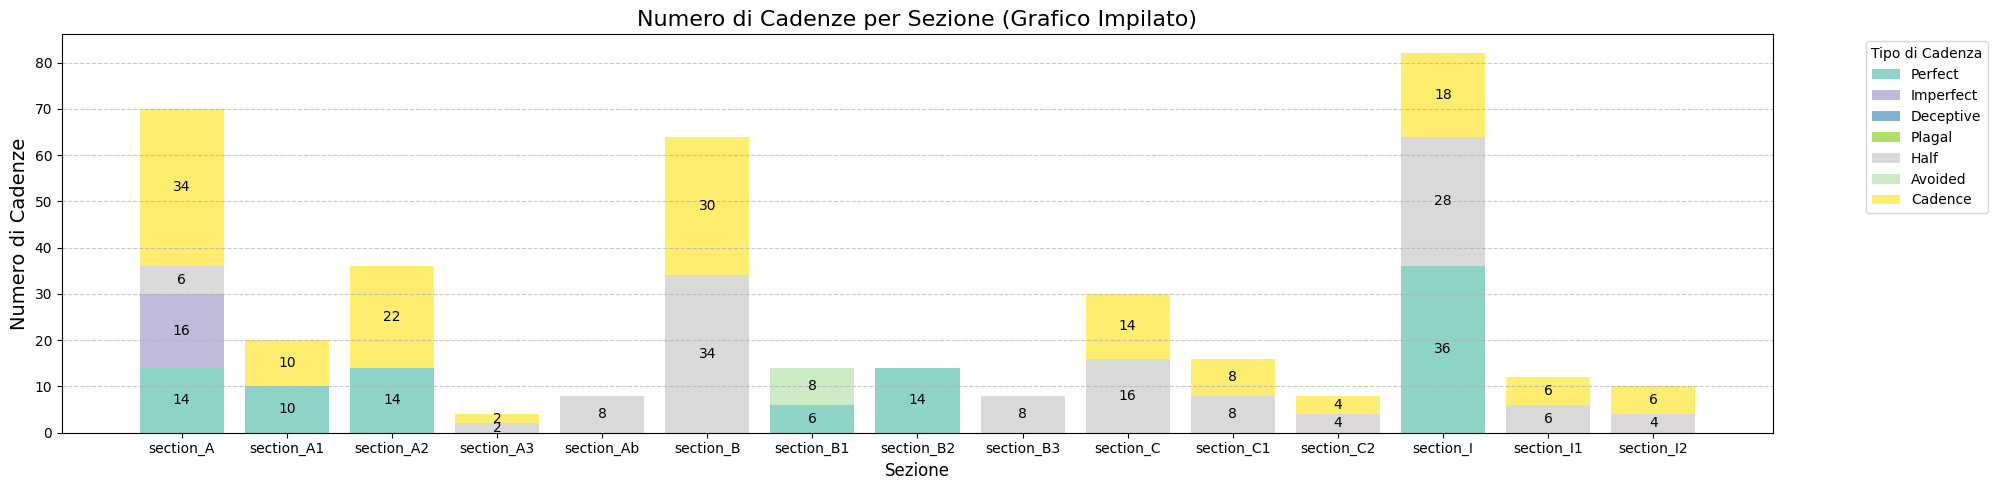

In [13]:
import matplotlib.pyplot as plt
import numpy as np


sections = [section for section in cadence_data.keys()]

cadence_types = ['Perfect', 'Imperfect', 'Deceptive', 'Plagal', 'Half', 'Avoided', 'Cadence']

counts_per_cadence = {cadence: [] for cadence in cadence_types}


for section in cadence_data:
    for cadence_type in cadence_types:
        counts_per_cadence[cadence_type].append(cadence_data[section].get(cadence_type, 0))

# Trasforma i dati in array per facilitarne l'uso nel grafico a barre impilate
data = np.array([counts_per_cadence[cadence] for cadence in cadence_types])

# grafico a barre impilate
fig, ax = plt.subplots(figsize=(20, 5))


bottom = np.zeros(len(sections))
colors = plt.cm.Set3(np.linspace(0, 1, len(cadence_types)))  # cambio colore

for i, cadence_type in enumerate(cadence_types):
    bars = ax.bar(sections, data[i], bottom=bottom, label=cadence_type, color=colors[i])

    # Aggiungi il numero delle cadenze su ogni barra impilata
    for bar, count in zip(bars, data[i]):
        if count > 0:
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2,
                    f'{int(count)}', ha='center', va='center', fontsize=10, color='black')

    bottom += data[i]

#etichette e titolo
ax.set_xlabel('Sezione', fontsize=12)
ax.set_ylabel('Numero di Cadenze', fontsize=14)
ax.set_title('Numero di Cadenze per Sezione (Grafico Impilato)', fontsize=16)

#egenda
ax.legend(title="Tipo di Cadenza", bbox_to_anchor=(1.05, 1), loc='upper left')

ax.grid(True, axis='y', linestyle='--', alpha=0.7)


plt.tight_layout()


plt.show()





In [14]:
from rdflib import Graph

def load_ontology(ontology_path):
    g = Graph()
    g.parse(ontology_path)
    return g

# Funzione per eseguire una query SPARQL che estrae le cadenze perfette, i gradi e gli accordi
def query_dettagli_cadenze_perfette(ontology_path):
    g = load_ontology(ontology_path)

    #query SPARQL per estrarre tutte le cadenze perfette con i gradi e gli accordi
    query = """
    PREFIX : <http://www.example.com/cadences.owl#>
    SELECT ?cadence ?section ?precedingDegree ?precedingChord ?followingDegree ?followingChord
    WHERE {
      ?cadence a :Perfect ;
               :belongsToSection ?section ;
               :hasPrecedingDegree ?precedingDegree ;
               :hasFollowingDegree ?followingDegree .
      ?precedingDegree :hasChord ?precedingChord .
      ?followingDegree :hasChord ?followingChord .
    }
    ORDER BY ?section
    """

    # Esegui
    results = g.query(query)

    # Stampa i risultati
    for row in results:
        cadence = str(row.cadence).split("#")[-1]
        section = str(row.section).split("#")[-1]
        preceding_degree = str(row.precedingDegree).split("#")[-1]
        preceding_chord = str(row.precedingChord).split("#")[-1]
        following_degree = str(row.followingDegree).split("#")[-1]
        following_chord = str(row.followingChord).split("#")[-1]

        print(f"Cadenza: {cadence}, Sezione: {section}")
        print(f"  Grado Precedente: {preceding_degree}, Accordo Precedente: {preceding_chord}")
        print(f"  Grado Seguente: {following_degree}, Accordo Seguente: {following_chord}")
        print("----------------------------------------------------------")

# Esempio di utilizzo
ontologia_path = 'ontologia_popolata.owl'
query_dettagli_cadenze_perfette(ontologia_path)

Cadenza: PerfectCadenceExample1, Sezione: SectionVerse
  Grado Precedente: Degree5, Accordo Precedente: G7Chord
  Grado Seguente: Degree1, Accordo Seguente: CMajorChord
----------------------------------------------------------
Cadenza: cadence_Perfect_A_78, Sezione: section_A
  Grado Precedente: :min, Accordo Precedente: _(3,5,b7)
  Grado Seguente: :min, Accordo Seguente: _(3,5)
----------------------------------------------------------
Cadenza: cadence_Perfect_A_276, Sezione: section_A
  Grado Precedente: degree_V_C:(3,5,b7)_F:min, Accordo Precedente: chord_C_(3,5,b7)
  Grado Seguente: degree_I_F:(3,5)_F:min, Accordo Seguente: chord_F_(3,5)
----------------------------------------------------------
Cadenza: cadence_Perfect_A_367, Sezione: section_A
  Grado Precedente: degree_V_E:(3,5,b7)_A:maj, Accordo Precedente: chord_E_(3,5,b7)
  Grado Seguente: degree_I_A:(3,5)_A:maj, Accordo Seguente: chord_A_(3,5)
----------------------------------------------------------
Cadenza: cadence_Perfe

In [15]:
from rdflib import Graph

def load_ontology(ontology_path):
    g = Graph()
    g.parse(ontology_path)
    return g

#query SPARQL che conta gli accordi precedenti e seguenti nelle cadenze perfette
def query_accordi_precedenti_e_seguenti_cadenze_perfette(ontology_path):
    g = load_ontology(ontology_path)

    # Query SPARQL per contare gli accordi precedenti e seguenti
    query = """
    PREFIX : <http://www.example.com/cadences.owl#>
    SELECT ?precedingChord ?followingChord (COUNT(?cadence) AS ?chordCount)
    WHERE {
      ?cadence a :Perfect ;
               :hasPrecedingDegree ?precedingDegree ;
               :hasFollowingDegree ?followingDegree .
      ?precedingDegree :hasChord ?precedingChord .
      ?followingDegree :hasChord ?followingChord .
    }
    GROUP BY ?precedingChord ?followingChord
    ORDER BY DESC(?chordCount)
    """

    results = g.query(query)

    for row in results:
        hash_index_preceding = str(row.precedingChord).index('#')
        hash_index_following = str(row.followingChord).index('#')

        preceding_chord = str(row.precedingChord)[hash_index_preceding+1:]
        following_chord = str(row.followingChord)[hash_index_following+1:]
        chord_count = int(row.chordCount.value)
        print(f"Accordo Precedente: {preceding_chord:<20} Accordo Seguente: {following_chord:<20} Conteggio: {chord_count:<10}")


ontologia_path = 'ontologia_senza_individuals.owl'
query_accordi_precedenti_e_seguenti_cadenze_perfette(ontologia_path)



Accordo Precedente: chord_A_(3,5)        Accordo Seguente: chord_D_(b3,5)       Conteggio: 16        
Accordo Precedente: chord_G_(3,5,b7)     Accordo Seguente: chord_C_(3,5)        Conteggio: 16        
Accordo Precedente: chord_C_(3,5,b7)     Accordo Seguente: chord_F_(3,5)        Conteggio: 14        
Accordo Precedente: chord_D_(3,5,b7)     Accordo Seguente: chord_G_(3,5)        Conteggio: 14        
Accordo Precedente: chord_C#_(3,5,b7)    Accordo Seguente: chord_F#_(3,5)       Conteggio: 8         
Accordo Precedente: chord_D_(3,5,b7)     Accordo Seguente: chord_G_(b3,5)       Conteggio: 6         
Accordo Precedente: chord_G_(3,5)        Accordo Seguente: chord_C_(b3,5)       Conteggio: 4         
Accordo Precedente: chord_C_(3,5,b7)     Accordo Seguente: chord_F_(b3,5)       Conteggio: 4         
Accordo Precedente: chord_F#_(3,5,b7)    Accordo Seguente: chord_B_(3,5)        Conteggio: 4         
Accordo Precedente: chord_C#_(3,5,b7)    Accordo Seguente: chord_F#_(b3,5)      Co

In [16]:
from rdflib import Graph

def load_ontology(ontology_path):
    g = Graph()
    g.parse(ontology_path)
    return g

# Funzione per query SPARQL che conta gli accordi precedenti e seguenti per ogni tonalità
def query_accordi_precedenti_e_seguenti_per_tonalita(ontology_path):
    g = load_ontology(ontology_path)

    # Query SPARQL per contare gli accordi precedenti e seguenti per ogni tonalità
    query = """
    PREFIX : <http://www.example.com/cadences.owl#>
    SELECT ?key ?precedingChord ?followingChord (COUNT(?cadence) AS ?cadenceCount)
    WHERE {
      ?cadence a :Perfect ;
               :hasPrecedingDegree ?precedingDegree ;
               :hasFollowingDegree ?followingDegree .
      ?precedingDegree :hasChord ?precedingChord ;
                       :hasKey ?key .
      ?followingDegree :hasChord ?followingChord ;
                       :hasKey ?key .
    }
    GROUP BY ?key ?precedingChord ?followingChord
    ORDER BY ?key DESC(?cadenceCount)
    """

    # Esegui query SPARQL
    results = g.query(query)

    #lista per i dati
    data = {
        'Tonalità': [],
        'Accordo Precedente': [],
        'Accordo Seguente': [],
        'Conteggio': []
    }

    print(f"Frequenza accordi per cadenza Perfetta")
    for row in results:
        hash_index_preceding = str(row.precedingChord).index('#')
        hash_index_following = str(row.followingChord).index('#')
        hash_index_key = str(row.key).index('#')

        preceding_chord = str(row.precedingChord)[hash_index_preceding+1:]  # Nome dell'accordo precedente
        following_chord = str(row.followingChord)[hash_index_following+1:]  # Nome dell'accordo seguente
        key = str(row.key)[hash_index_key+1:]  # Nome della tonalità
        cadence_count = int(row.cadenceCount.value)  # Conteggio delle cadenze

        print(f"Tonalità: {key:<10} Accordo Precedente: {preceding_chord:<20} Accordo Seguente: {following_chord:<20} Conteggio: {cadence_count:<10}")

        # dizionario dati
        data['Tonalità'].append(key)
        data['Accordo Precedente'].append(preceding_chord)
        data['Accordo Seguente'].append(following_chord)
        data['Conteggio'].append(cadence_count)

    return data

ontologia_path = 'ontologia_senza_individuals.owl'
data = query_accordi_precedenti_e_seguenti_per_tonalita(ontologia_path)



Frequenza accordi per cadenza Perfetta
Tonalità: key_A_maj  Accordo Precedente: chord_E_(3,5,b7)     Accordo Seguente: chord_A_(3,5)        Conteggio: 2         
Tonalità: key_B_maj  Accordo Precedente: chord_F#_(3,5,b7)    Accordo Seguente: chord_B_(3,5)        Conteggio: 4         
Tonalità: key_C_maj  Accordo Precedente: chord_G_(3,5,b7)     Accordo Seguente: chord_C_(3,5)        Conteggio: 16        
Tonalità: key_C_min  Accordo Precedente: chord_G_(3,5)        Accordo Seguente: chord_C_(b3,5)       Conteggio: 4         
Tonalità: key_D_min  Accordo Precedente: chord_A_(3,5)        Accordo Seguente: chord_D_(b3,5)       Conteggio: 16        
Tonalità: key_D_min  Accordo Precedente: chord_A_(3,5,b7)     Accordo Seguente: chord_D_(b3,5)       Conteggio: 2         
Tonalità: key_F#_min Accordo Precedente: chord_C#_(3,5,b7)    Accordo Seguente: chord_F#_(3,5)       Conteggio: 8         
Tonalità: key_F#_min Accordo Precedente: chord_C#_(3,5,b7)    Accordo Seguente: chord_F#_(b3,5)     

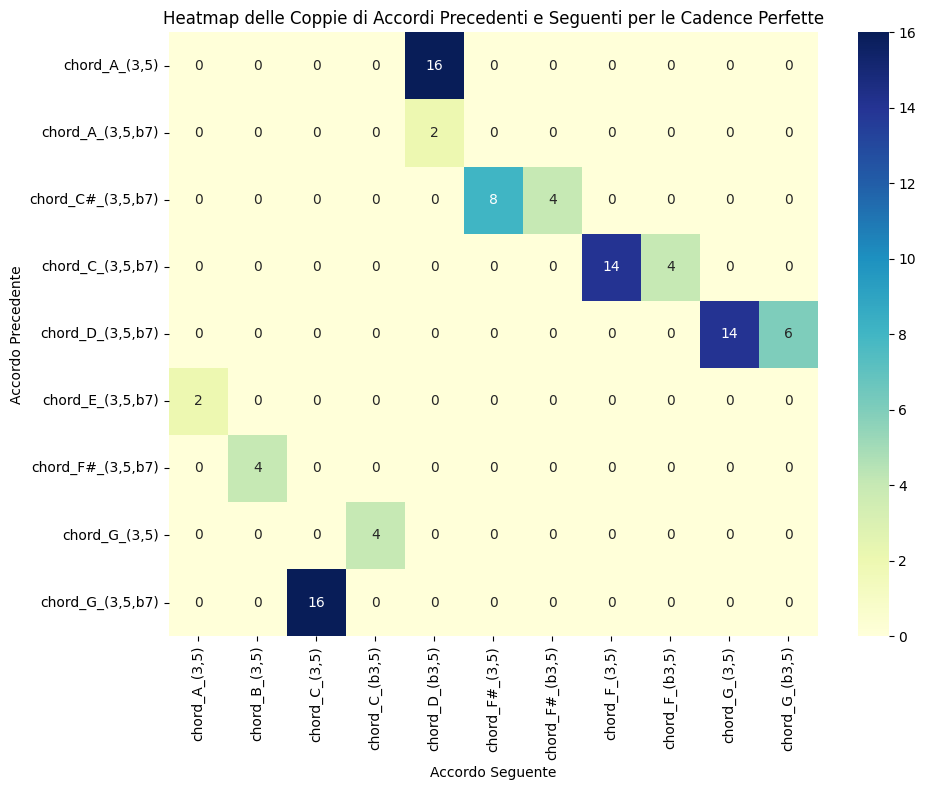

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def create_heatmap(data):
    # Crea un DataFrame per dati
    df = pd.DataFrame(data)

    pivot_table = df.pivot_table(
        values='Conteggio',  # Il valore da visualizzare
        index='Accordo Precedente',  # Riga: Accordo Precedente
        columns='Accordo Seguente',  # Colonna: Accordo Seguente
        aggfunc='sum',  # Somma i valori
        fill_value=0  # Riempie i valori mancanti con 0
    )

    # heatmap utilizzando seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_table, annot=True, fmt="d", cmap="YlGnBu", cbar=True)

    # etichette e titolo
    plt.title("Heatmap delle Coppie di Accordi Precedenti e Seguenti per le Cadence Perfette")
    plt.xlabel("Accordo Seguente")
    plt.ylabel("Accordo Precedente")


    plt.tight_layout()
    plt.show()



create_heatmap(data)


In [18]:
from rdflib import Graph

def load_ontology(ontology_path):
    g = Graph()
    g.parse(ontology_path)
    return g

# Funzione per  query SPARQL che conta le cadenze per tonalità e tipologia
def query_conta_cadenze_per_tonalita_e_tipologia(ontology_path):

    g = load_ontology(ontology_path)

    # Query SPARQL per contare le cadenze per tonalità e tipologia
    query = """
    PREFIX : <http://www.example.com/cadences.owl#>
    SELECT ?key ?cadenceType (COUNT(?cadence) AS ?cadenceCount)
    WHERE {
      ?cadence a ?cadenceType ;
               :hasFollowingDegree ?followingDegree ;
      { ?followingDegree :hasKey ?key }


      FILTER(?cadenceType IN (:Perfect, :Imperfect, :Deceptive, :Plagal, :Half, :Cadence, :Avoided))
    }
    GROUP BY ?key ?cadenceType
    ORDER BY ?key DESC(?cadenceCount)
    """

    # Esegui query.
    results = g.query(query)


    key_data = {}
    for row in results:
        hash_index = str(row.key).index('#')
        key = str(row.key)[hash_index+1:]  # Prendo il nome della tonalità
        cadence_type = str(row.cadenceType).split("#")[-1]  # Prendo il nome del tipo di cadenza
        cadence_count = int(row.cadenceCount)  # Conteggio delle cadenze per tipo
        print(f"Tonalità: {key:<10} Tipo di cadenza: {cadence_type:<15} Conteggio: {cadence_count:<10}")
        if key not in key_data:
            key_data[key] = {}

        key_data[key][cadence_type] = cadence_count

    return key_data


ontologia_path = 'ontologia_senza_individuals.owl'
key_data = query_conta_cadenze_per_tonalita_e_tipologia(ontologia_path)


Tonalità: key_A_maj  Tipo di cadenza: Half            Conteggio: 4         
Tonalità: key_A_maj  Tipo di cadenza: Cadence         Conteggio: 2         
Tonalità: key_A_maj  Tipo di cadenza: Perfect         Conteggio: 2         
Tonalità: key_A_min  Tipo di cadenza: Half            Conteggio: 18        
Tonalità: key_A_min  Tipo di cadenza: Cadence         Conteggio: 8         
Tonalità: key_B_maj  Tipo di cadenza: Perfect         Conteggio: 4         
Tonalità: key_B_min  Tipo di cadenza: Half            Conteggio: 18        
Tonalità: key_B_min  Tipo di cadenza: Cadence         Conteggio: 12        
Tonalità: key_Bb_min Tipo di cadenza: Cadence         Conteggio: 28        
Tonalità: key_Bb_min Tipo di cadenza: Half            Conteggio: 2         
Tonalità: key_C_maj  Tipo di cadenza: Perfect         Conteggio: 16        
Tonalità: key_C_maj  Tipo di cadenza: Half            Conteggio: 8         
Tonalità: key_C_min  Tipo di cadenza: Half            Conteggio: 40        
Tonalità: ke

In [19]:
key_data

{'key_A_maj': {'Half': 4, 'Cadence': 2, 'Perfect': 2},
 'key_A_min': {'Half': 18, 'Cadence': 8},
 'key_B_maj': {'Perfect': 4},
 'key_B_min': {'Half': 18, 'Cadence': 12},
 'key_Bb_min': {'Cadence': 28, 'Half': 2},
 'key_C_maj': {'Perfect': 16, 'Half': 8},
 'key_C_min': {'Half': 40, 'Cadence': 10, 'Imperfect': 4, 'Perfect': 4},
 'key_D#_min': {'Cadence': 2},
 'key_D_maj': {'Half': 4},
 'key_D_min': {'Cadence': 26, 'Perfect': 18, 'Imperfect': 12, 'Half': 4},
 'key_E_maj': {'Half': 4},
 'key_F#_min': {'Perfect': 12},
 'key_F_maj': {'Half': 4},
 'key_F_min': {'Perfect': 18, 'Cadence': 6, 'Half': 4, 'Avoided': 2},
 'key_G_maj': {'Half': 4, 'Perfect': 2, 'Cadence': 2},
 'key_G_min': {'Perfect': 18, 'Cadence': 12, 'Half': 10, 'Avoided': 6}}

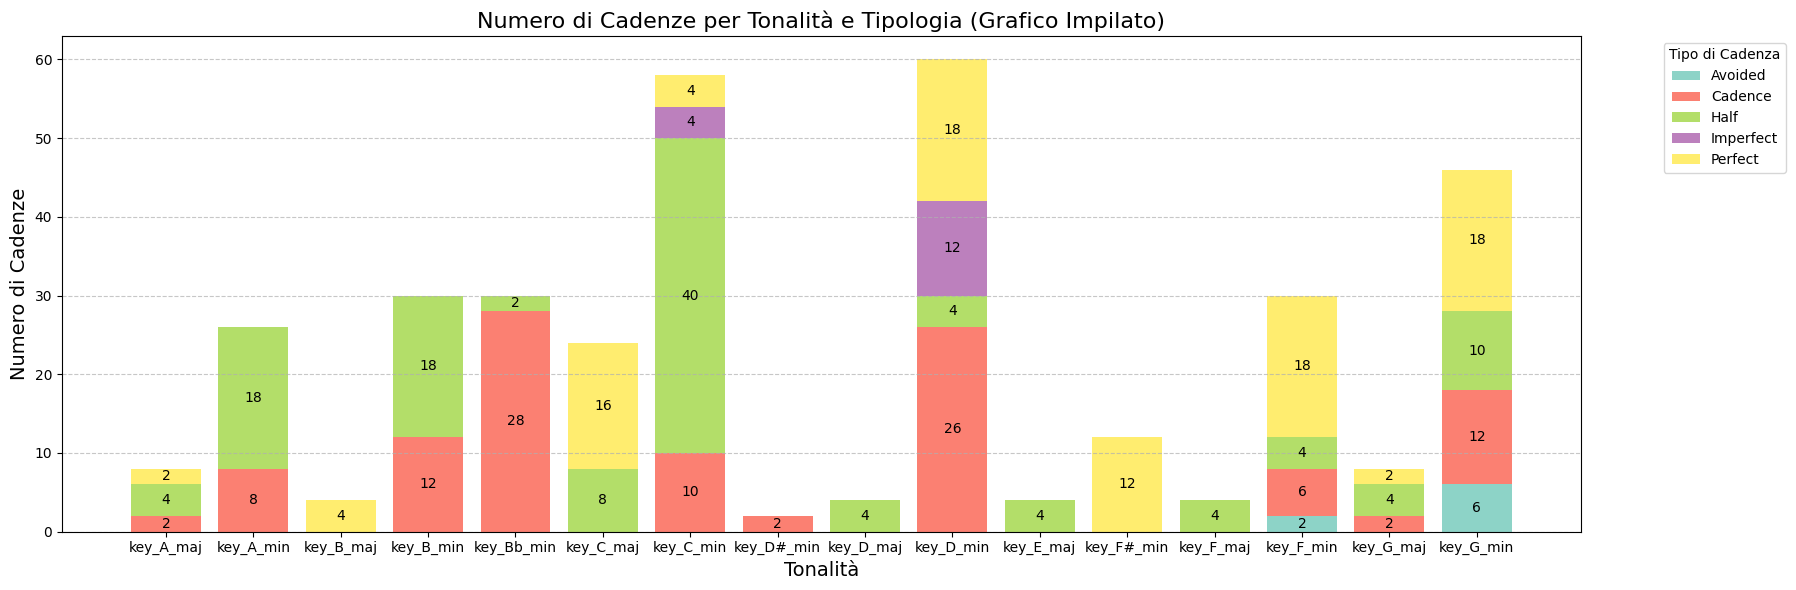

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def plot_stacked_bar_chart_with_numbers(cadence_data):
    # Estrai tutte le tonalità e tipi di cadenze unici
    keys = list(cadence_data.keys())

    all_cadence_types = set()
    for key in keys:
        all_cadence_types.update(cadence_data[key].keys())
    cadence_types = sorted(list(all_cadence_types))

    n_keys = len(keys)
    n_cadence_types = len(cadence_types)

    # struttura per contare le cadenze per tonalità e tipo di cadenza
    cadence_counts = np.zeros((n_cadence_types, n_keys))
    for i, cadence_type in enumerate(cadence_types):
        for j, key in enumerate(keys):
            cadence_counts[i, j] = cadence_data[key].get(cadence_type, 0)

    #grafico a barre impilate
    fig, ax = plt.subplots(figsize=(18, 6))

    #palette
    colors = plt.cm.Set3(np.linspace(0, 1, n_cadence_types))

    bottom = np.zeros(n_keys)

    # Aggiungo  barre impilate
    for i, cadence_type in enumerate(cadence_types):
        bars = ax.bar(keys, cadence_counts[i], label=cadence_type, bottom=bottom, color=colors[i])

        # Aggiungo  numero di cadenze dentro le barre
        for bar, count in zip(bars, cadence_counts[i]):
            if count > 0:
                ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2,
                        f'{int(count)}', ha='center', va='center', fontsize=10, color='black')

        bottom += cadence_counts[i]

    # etichette e titolo
    ax.set_xlabel('Tonalità', fontsize=14)
    ax.set_ylabel('Numero di Cadenze', fontsize=14)
    ax.set_title('Numero di Cadenze per Tonalità e Tipologia (Grafico Impilato)', fontsize=16)

    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    # legenda
    ax.legend(title="Tipo di Cadenza", bbox_to_anchor=(1.05, 1), loc='upper left')


    plt.tight_layout()


    plt.show()




plot_stacked_bar_chart_with_numbers(key_data)



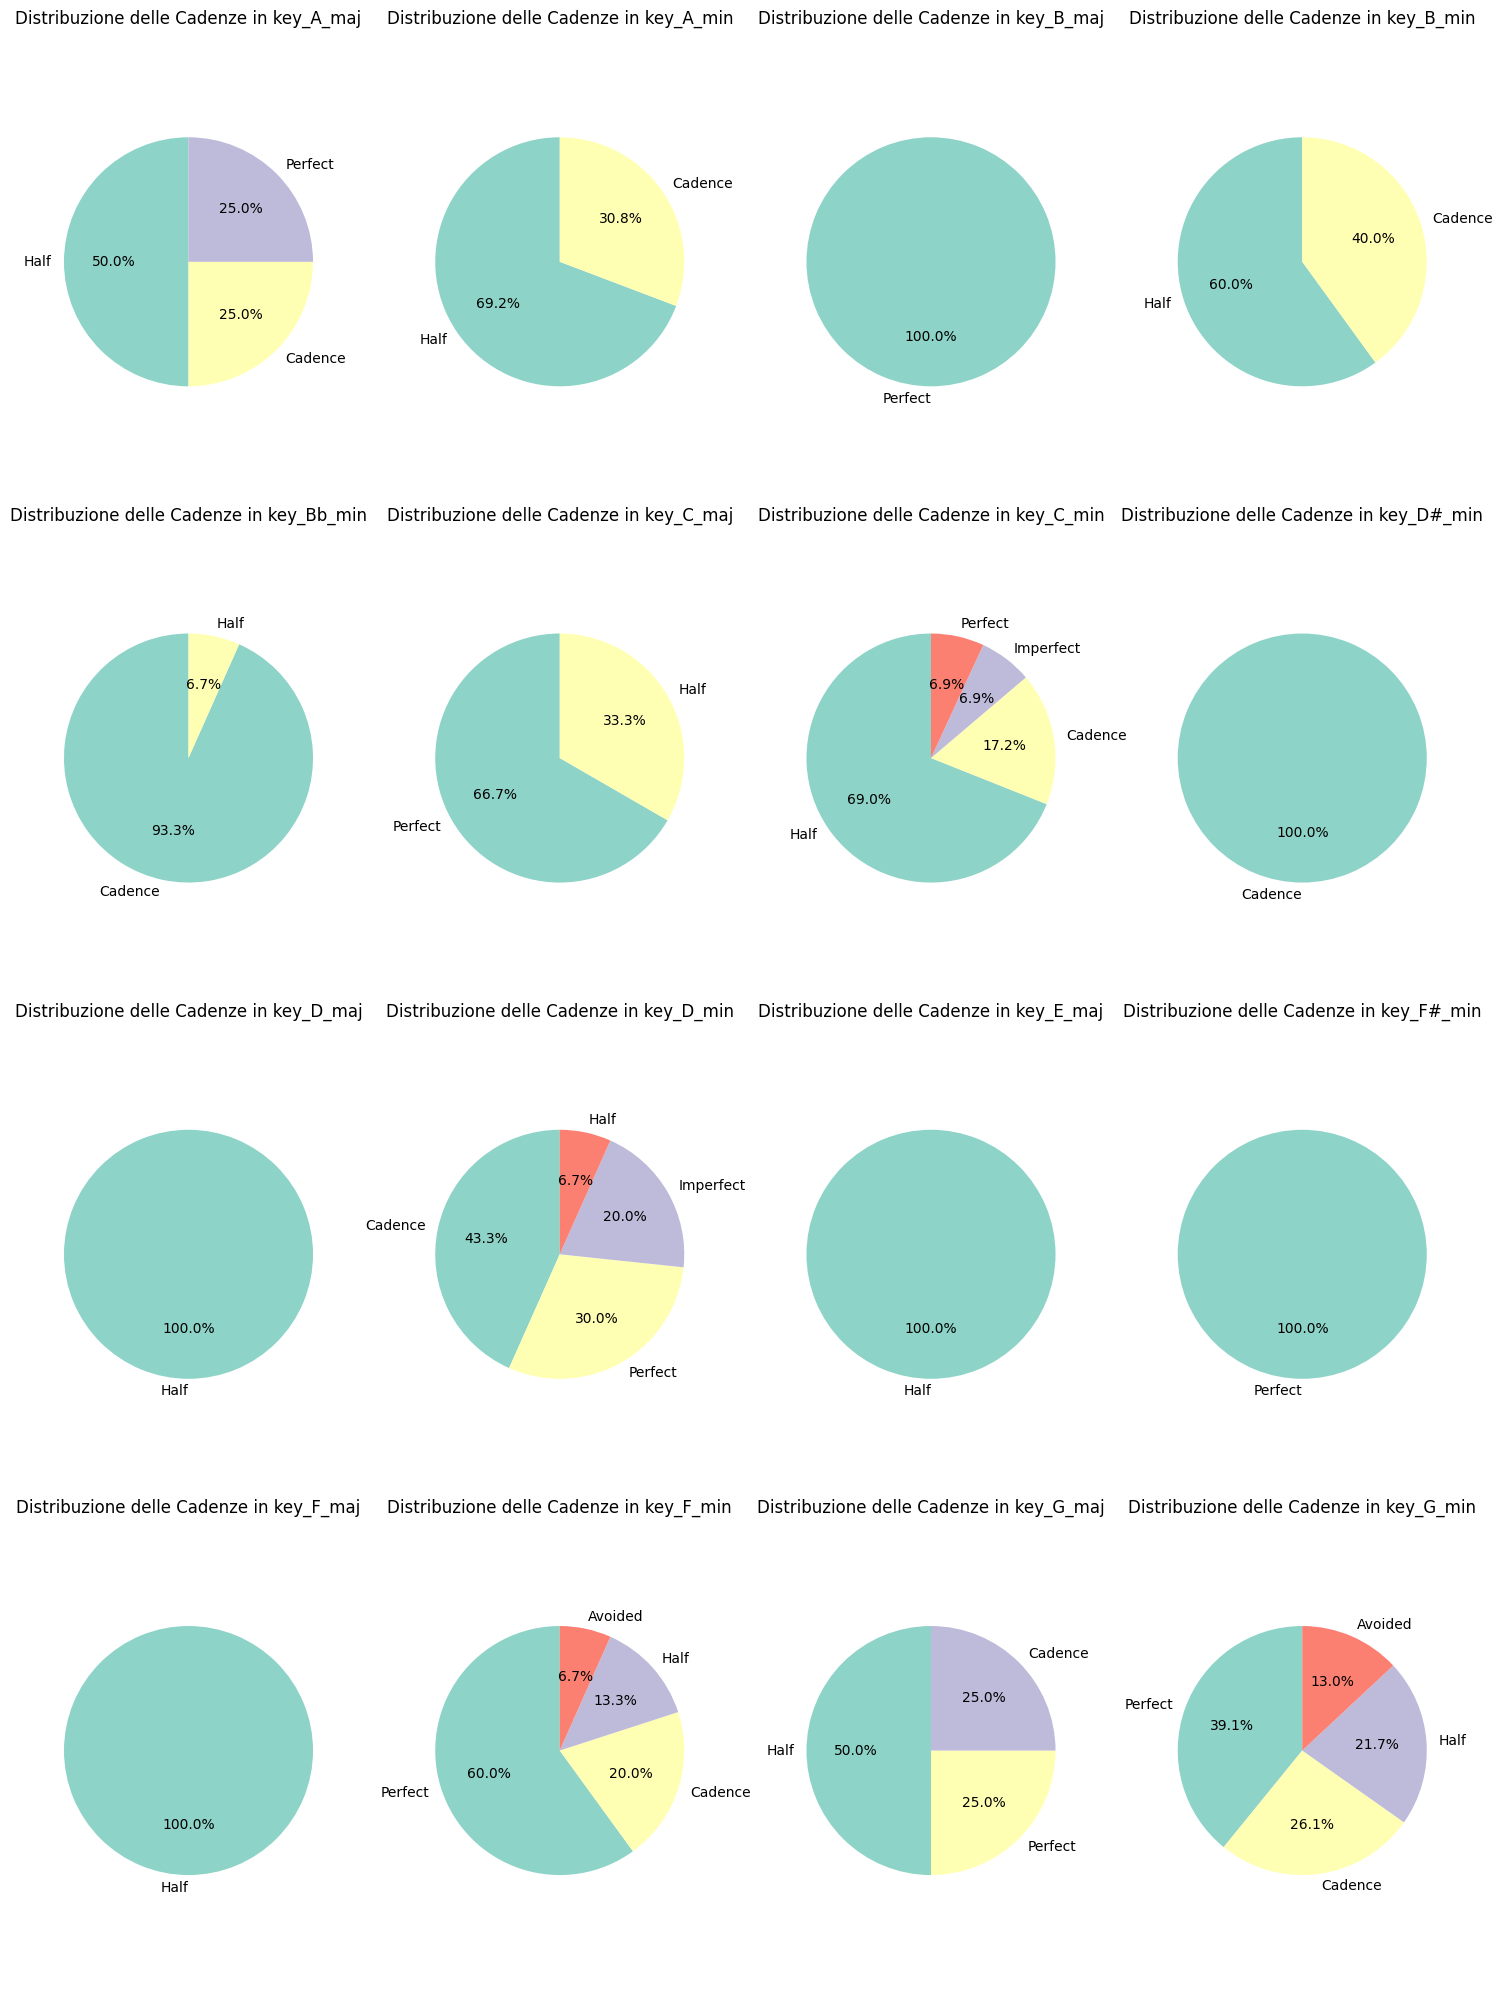

In [22]:
import matplotlib.pyplot as plt

def plot_cadence_distribution(cadence_data):
    # numero di colonne per i subplot
    num_columns = 4
    num_keys = len(cadence_data)
    num_rows = (num_keys // num_columns) + (num_keys % num_columns > 0)

    # subplot con dimensione adeguata
    fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))

    axs = axs.ravel()  # Rende il vettore di assi "piatto" per iterarci facilmente

    # Iteriamo su  tonalità
    for i, (key, cadences) in enumerate(cadence_data.items()):
        # Calcolo il totale delle cadenze per la tonalità corrente
        total_cadences = sum(cadences.values())

        # Calcolo  percentuali
        percentages = {cadence_type: (count / total_cadences) * 100 for cadence_type, count in cadences.items()}


        labels = list(percentages.keys())
        sizes = list(percentages.values())
        colors = plt.cm.Set3(range(len(labels)))  # Utilizza una palette di colori chiara

        # grafico a torta nel subplot corrente
        axs[i].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)

        # titolo
        axs[i].set_title(f'Distribuzione delle Cadenze in {key}')


        axs[i].axis('equal')

    # Rimuovi  assi vuoti se ci sono più subplot di quelli necessari
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])


    plt.tight_layout()
    plt.show()

plot_cadence_distribution(key_data)
